In [1]:
!sudo apt-get install python3.9

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpython3.9-minimal libpython3.9-stdlib mailcap mime-support
  python3.9-minimal
Suggested packages:
  python3.9-venv binfmt-support
The following NEW packages will be installed:
  libpython3.9-minimal libpython3.9-stdlib mailcap mime-support python3.9
  python3.9-minimal
0 upgraded, 6 newly installed, 0 to remove and 45 not upgraded.
Need to get 5,275 kB of archives.
After this operation, 19.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 mailcap all 3.70+nmu1ubuntu1 [23.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 mime-support all 3.66 [3,696 B]
Get:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 libpython3.9-minimal amd64 3.9.19-1+jammy1 [835 kB]
Get:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 python3.9-minima

In [2]:
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 1

update-alternatives: using /usr/bin/python3.9 to provide /usr/bin/python3 (python3) in auto mode


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!python --version

Python 3.9.19


In [99]:
#import libraries
import tensorflow as tf
import pandas as pd
import re
import nltk
import zipfile
import os
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Orthogonal
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import pickle

i trained my models in colab so i had to secure that my local tf version is the same (2.15.0) with colab's tf version. A different tf version can't load the models.

In [6]:
#! pip install --upgrade tensorflow

In [7]:
print(tf.__version__)

2.15.0


In [8]:
# Function to check if GPU is available and set the device
def get_device():
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        device_name = physical_devices[0].name
        print(f"Running on GPU: {device_name}")
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    else:
        device_name = '/CPU:0'
        print("Running on CPU")
    return device_name


I downloaded the datasets for kaggle.
The training dataset has 74681 entries and the test dataset 1000 entries

In [9]:
#load the training data
df = pd.read_csv('/content/gdrive/MyDrive/deep learning project1/twitter_training.csv')

In [10]:
df

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


In [11]:
#load the testing data
test = pd.read_csv('/content/gdrive/MyDrive/deep learning project1/twitter_test.csv')

In [12]:
test

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...,...,...
994,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
997,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


The dataset has four columns.
The fourth column has the tweets/text.
The third column has the labels of the tweets(irrelevant, negative, neutreal, possitive).
The second column has the name of the game/company/brand, the tweet talks about.
The first column is the ID of the game/company/brand.


In [13]:
#add headers
df.columns = ['theme_id', 'theme','class_labels','text']
test.columns = ['theme_id', 'theme','class_labels','text']
df

,theme_id,theme,class_labels,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


In [14]:
test

,theme_id,theme,class_labels,text
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...,...,...
994,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
997,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


I dropped the id of the game/company/brand because i couldn't find any way to use it and the theme. Also i trained a model with a concatenation of the theme and the tweet/text but the results were slightly worse so i kelt the model without the concatenation.

In [15]:
#delete the theme_id and theme columns (not needed for the model)
df.drop(columns=['theme_id', 'theme'], inplace=True)
test.drop(columns=['theme_id', 'theme'], inplace=True)
df

,class_labels,text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
74676,Positive,Just realized that the Windows partition of my...
74677,Positive,Just realized that my Mac window partition is ...
74678,Positive,Just realized the windows partition of my Mac ...
74679,Positive,Just realized between the windows partition of...


In [16]:
test

,class_labels,text
0,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Negative,@Microsoft Why do I pay for WORD when it funct...
2,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,Neutral,Now the President is slapping Americans in the...
4,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...
994,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,Positive,Today sucked so it’s time to drink wine n play...
997,Positive,Bought a fraction of Microsoft today. Small wins.


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   class_labels  74681 non-null  object
 1   text          73995 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   class_labels  999 non-null    object
 1   text          999 non-null    object
dtypes: object(2)
memory usage: 15.7+ KB


I dropped the entries with null values and the duplicates.

In [19]:
#check for missing values
df.isnull().sum()

class_labels      0
text            686
dtype: int64

In [20]:
test.isnull().sum()

class_labels    0
text            0
dtype: int64

In [21]:
#drop missing values
df.dropna(inplace=True)
df.isnull().sum()

class_labels    0
text            0
dtype: int64

In [22]:
#check for duplicates
df.duplicated().sum()

4227

In [23]:
test.duplicated().sum()

1

In [24]:
#drop duplicates
df.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [25]:
test.duplicated().sum()

0

Downloaded all the tools i need from nltk

In [26]:
#nltk path
nltk_data_dir = '/content/gdrive/MyDrive/deep learning project1/nltk_rep'
wordnet_zip_path = os.path.join(nltk_data_dir, 'corpora/wordnet.zip')
omw_zip_path = os.path.join(nltk_data_dir, 'corpora/omw-1.4.zip')
wordnet_dir = os.path.join(nltk_data_dir, 'corpora/wordnet')
omw_dir = os.path.join(nltk_data_dir, 'corpora/omw-1.4')
punkt_dir = os.path.join(nltk_data_dir, 'corpora/punkt')
stopwords_dir = os.path.join(nltk_data_dir, 'corpora/stopwords')

for some reason it duplicates the wordnet and omw folders and i have to delele them manually

In [27]:
#check if the files are already downloaded
os.makedirs(nltk_data_dir, exist_ok=True)

In [28]:
#Download NLTK data if not already downloaded
if not os.path.exists(wordnet_zip_path):
    nltk.download('wordnet', download_dir=nltk_data_dir)
if not os.path.exists(omw_zip_path):
    nltk.download('omw-1.4', download_dir=nltk_data_dir)
if not os.path.exists(stopwords_dir):
    nltk.download('stopwords', download_dir=nltk_data_dir)
#if not os.path.exists(punkt_dir):
    #nltk.download('punkt', download_dir=nltk_data_dir)


wordnet and omw were zipped so i had to unzip them

In [29]:
#define function to unzip files
def unzip_file(zip_path, extract_to):
    if not os.path.exists(extract_to):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)

In [30]:
#unzip the downloaded files if not already unzipped
unzip_file(wordnet_zip_path, wordnet_dir)
unzip_file(omw_zip_path, omw_dir)

In [31]:
#add nlltk path
nltk.data.path.append(nltk_data_dir)

In [32]:
#define that the data is accessible
try:
    from nltk.corpus import wordnet
    print("WordNet is available.")
except Exception as e:
    print(f"Error accessing WordNet: {e}")

try:
    from nltk.corpus import wordnet
    # Access synsets to ensure OMW 1.4 is integrated
    example_synset = wordnet.synsets('example')
    if example_synset:
        print("OMW 1.4 data is integrated and available.")
    else:
        print("OMW 1.4 data is not found.")
except Exception as e:
    print(f"Error accessing OMW 1.4 data: {e}")
try:
    from nltk.corpus import stopwords
    print("Stopwords are available.")
except Exception as e:
    print(f"Error accessing Stopwords: {e}")
#try:
    #from nltk.tokenize.punkt import WordPunctTokenizer
    #print("punkt are available.")
#except Exception as e:
    #print(f"Error accessing punkt: {e}")

WordNet is available.
OMW 1.4 data is integrated and available.
Stopwords are available.


Creating a function to clean the text. The steps that i did to build this function were: Initialy removed the extra spaces, special characters, single characters and non alphabetical characters. Then i change all the characters to lower, split the text into single words and lemmatize all the words. Also i removed all the words stopwords library includes and after trials found out that the accuracy increases if i remove  the duplicates from the same entry. Finally, after all these, the removing of all words with length< 2 improved  my model.

In [33]:
def process_text(text):
    #remove extra spaces
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    #remove special characters
    text = re.sub(r'\W', ' ', str(text))
    #remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    #remove non alphabetical characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    text = text.lower()

    words = word_tokenize(text)

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    stop_words = set(stopwords.words("english"))
    Words = [word for word in words if word not in stop_words]

    Words = [word for word in Words if len(word) > 2]

    indices = np.unique(Words, return_index=True)[1]
    cleaned_text = np.array(Words)[np.sort(indices)].tolist()

    return cleaned_text

In [34]:
# get the text column to apply the function in  the training data
x=df.drop('class_labels',axis=1)
y=df.class_labels
texts=list(x['text'])

In [35]:
x

,text
0,I am coming to the borders and I will kill you...
1,im getting on borderlands and i will kill you ...
2,im coming on borderlands and i will murder you...
3,im getting on borderlands 2 and i will murder ...
4,im getting into borderlands and i can murder y...
...,...
74676,Just realized that the Windows partition of my...
74677,Just realized that my Mac window partition is ...
74678,Just realized the windows partition of my Mac ...
74679,Just realized between the windows partition of...


In [36]:
y

0        Positive
1        Positive
2        Positive
3        Positive
4        Positive
           ...   
74676    Positive
74677    Positive
74678    Positive
74679    Positive
74680    Positive
Name: class_labels, Length: 69768, dtype: object

In [ ]:
texts

In [38]:
# get the text column to apply the function in  the testing data
x_test=test.drop('class_labels',axis=1)
y_test=test.class_labels
texts_test=list(x_test['text'])

In [39]:
#clean the texts
cleaned_text = [process_text(text) for text in texts]
cleaned_text_test = [process_text(text) for text in texts_test]

In [ ]:
cleaned_text

In [ ]:
cleaned_text_test

already have test data so i just split for validation

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(cleaned_text, y, test_size=0.1, random_state=42)

tokenization and zero padding of train, validation and test cleaned texts.

In [43]:
# Tokenize the text data
from tensorflow.keras.preprocessing.text import Tokenizer
max_vocab = 30000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_val)
tokenizer.fit_on_texts(cleaned_text_test)
word_idx = tokenizer.word_index
v = len(word_idx)
print("the size of vocab =", v)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(cleaned_text_test)

the size of vocab = 26839


In [ ]:
X_train

In [ ]:
X_val

In [ ]:
X_test

In [47]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 100
X_train = pad_sequences(X_train,maxlen=maxlen)
X_val = pad_sequences(X_val,maxlen=maxlen)
X_test = pad_sequences(X_test,maxlen=maxlen)

In [48]:
X_train

array([[    0,     0,     0, ...,  3630,   193,   767],
       [    0,     0,     0, ...,     0,   222,   645],
       [    0,     0,     0, ...,     6,     1, 11496],
       ...,
       [    0,     0,     0, ...,   269,   193,   411],
       [    0,     0,     0, ...,     0,  1666,   192],
       [    0,     0,     0, ...,    80,   726,    28]], dtype=int32)

In [49]:
X_val

array([[    0,     0,     0, ...,   261,  2022,   313],
       [    0,     0,     0, ...,    92,   445,  6147],
       [    0,     0,     0, ...,    32,    78,  2233],
       ...,
       [    0,     0,     0, ...,   154,     2,  1148],
       [    0,     0,     0, ...,   164,    72, 16633],
       [    0,     0,     0, ...,    18, 17292,  9669]], dtype=int32)

In [50]:
X_test

array([[    0,     0,     0, ...,  1145,  6677,  9807],
       [    0,     0,     0, ...,  2092, 12003,  5168],
       [    0,     0,     0, ...,   516,  1120,     2],
       ...,
       [    0,     0,     0, ...,   152,    22,   353],
       [    0,     0,     0, ...,    50,   518,   113],
       [    0,     0,     0, ...,  2767,    18, 10720]], dtype=int32)

In [51]:
y.value_counts()

class_labels
Negative      21237
Positive      19137
Neutral       17110
Irrelevant    12284
Name: count, dtype: int64

In [52]:
# Set device
device = get_device()

Running on CPU


i tried to create a learning rate function with the assist of early stopping

In [53]:
# Define the learning rate
def lr_schedule(epoch, lr):
    if epoch < 20:
        return 0.0001
    elif epoch < 40:
        return 0.00001
    elif epoch < 60:
        return 0.000001
    else:
        return 0.0000001

In [54]:
# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [55]:
D=100
# Define the input shape
inputt=Input(shape=(maxlen,))

In [56]:
# layers
x = Embedding(input_dim=v+1, output_dim=D)(inputt)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(150))(x)
x = Dense(32, activation='relu')(x)
x = Dense(4, activation='softmax')(x)

In [57]:
# Define the model with the device
#with tf.device(device):
model = Model(inputs=inputt, outputs=x)

In [58]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          2684000   
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 bidirectional (Bidirection  (None, 300)               301200    
 al)                                                             
                                                                 
 dense (Dense)               (None, 32)                9632      
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                             

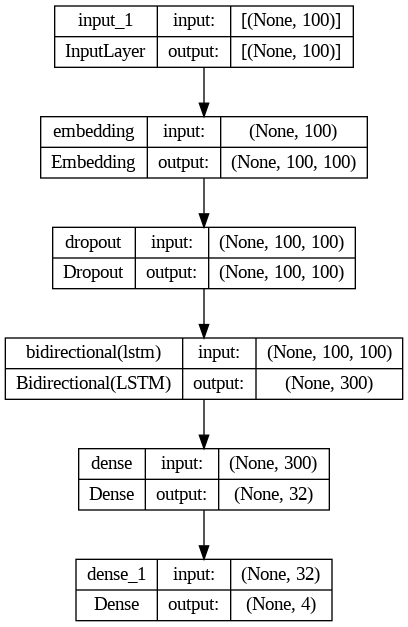

In [59]:
from keras.utils import plot_model
plot_model(model, to_file="model.png", show_shapes=True)

In [60]:
# Define optimizer with specified learning rate
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the device being used
print(f"Using device: {device}")

Using device: /CPU:0


In [61]:
# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

In [62]:
y_train_encoded

array([0, 1, 3, ..., 1, 2, 3])

In [63]:
# Convert the encoded labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded)
y_val_one_hot = tf.keras.utils.to_categorical(y_val_encoded)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded)

In [64]:
y_train_one_hot

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [65]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_path = '/content/gdrive/MyDrive/deep learning project1/LSTM200_5_sentiment_model.h5'

training/loading

In [66]:
# Check if the model already exists to avoid retraining
try:
        trained_model = tf.keras.models.load_model(model_path)
        print(f"Model loaded from {model_path}")
except IOError:
        model_checkpoint = ModelCheckpoint(filepath=model_path,
                                   monitor='val_loss',
                                   save_best_only=True,
                                   mode='min',
                                   save_weights_only=False,
                                   verbose=1)
        # Train the model
        history = model.fit(X_train, y_train_one_hot, epochs=100,batch_size=128, validation_data=(X_val, y_val_one_hot), callbacks=[early_stopping, model_checkpoint, lr_scheduler])
        # Save the model after training
        model.save(model_path)
        with open('/content/gdrive/MyDrive/deep learning project1/history.pkl', 'wb') as file:
            pickle.dump(history, file)
        print(f"Model saved to {model_path}")
        trained_model = tf.keras.models.load_model(model_path)

Model loaded from /content/gdrive/MyDrive/deep learning project1/LSTM200_5_sentiment_model.h5


In [67]:
with open('/content/gdrive/MyDrive/deep learning project1/history.pkl', 'rb') as file:
   history = pickle.load(file)

In [68]:
#y_train_pred = trained_model.predict(X_train)
#y_train_pred

In [69]:
#y_train_pred.shape

In [70]:
#y_test_one_hot.shape

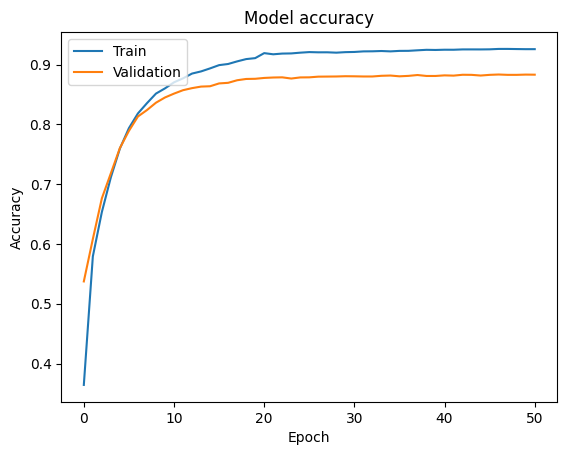

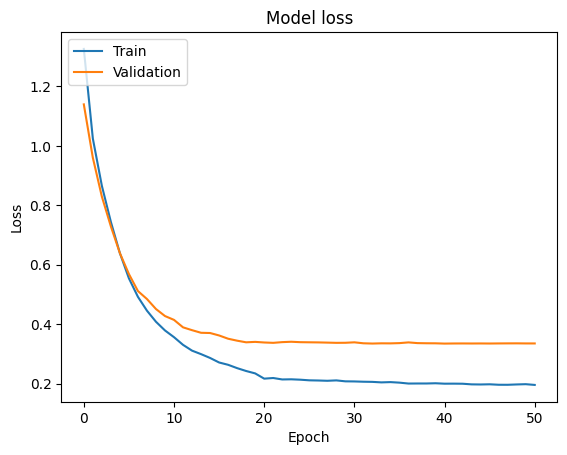

In [71]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [72]:
X_test

array([[    0,     0,     0, ...,  1145,  6677,  9807],
       [    0,     0,     0, ...,  2092, 12003,  5168],
       [    0,     0,     0, ...,   516,  1120,     2],
       ...,
       [    0,     0,     0, ...,   152,    22,   353],
       [    0,     0,     0, ...,    50,   518,   113],
       [    0,     0,     0, ...,  2767,    18, 10720]], dtype=int32)

In [73]:
model_probs = trained_model.predict(X_test)

###model_pred = (model_probs >= 0.5).astype(int)###
model_pred = np.zeros_like(model_probs)
# Find the index of the maximum probability in each row
max_indices = np.argmax(model_probs, axis=1)
# Set the maximum probability position to 1
model_pred[np.arange(model_probs.shape[0]), max_indices] = 1
print(model_pred)

32/32 [==============================] - 6s 159ms/step
[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


In [74]:
# Flatten the arrays for evaluation
y_true = y_test_one_hot.flatten()
y_pred = model_pred.flatten()

In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [76]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

In [90]:
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9785
Precision: 0.9713
Recall: 0.9713
F1 Score: 0.9713


In [78]:
# Print detailed classification report
print('\nClassification Report:')
print(classification_report(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2994
         1.0       0.96      0.96      0.96       998

    accuracy                           0.98      3992
   macro avg       0.97      0.97      0.97      3992
weighted avg       0.98      0.98      0.98      3992



[irrelevant, negative, neutreal, possitive]

In [79]:
sample = "i killed my neighbor and i will play dota2 all night long"
sample = process_text(sample)
sample = tokenizer.texts_to_sequences([sample])
sample = pad_sequences(sample, maxlen=maxlen)
sample = trained_model.predict(sample)
model_pred = np.zeros_like(sample)
max_indices = np.argmax(sample, axis=1)
model_pred[np.arange(sample.shape[0]), max_indices] = 1
print(model_pred)

1/1 [==============================] - 0s 46ms/step
[[0. 0. 0. 1.]]


# Import a pre-trained Bert model


In [100]:
import transformers
from transformers import BertTokenizer, TFBertModel, BertConfig
from transformers import glue_convert_examples_to_features
from transformers import InputExample, InputFeatures
# Check the version of the transformers library
print(transformers.__version__)

4.41.2


In [109]:
MAX_LEN=128

In [83]:
# Load the BERT Tokenizer and Model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
config = BertConfig.from_pretrained(model_name)
bert_model = TFBertModel.from_pretrained(model_name, config=config, from_pt=True, trainable=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exact

In [105]:
# Define a function to tokenize the texts
def tokenize_texts(texts, tokenizer, max_len=MAX_LEN):
    encodings = tokenizer(
        texts,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
    )
    return encodings

In [106]:
# split the data
X_train, X_val, y_train, y_val = train_test_split(texts, df['class_labels'], test_size=0.1, random_state=42)

train_encodings = tokenize_texts(X_train, tokenizer)
val_encodings = tokenize_texts(X_val, tokenizer)
test_encodings = tokenize_texts(test['text'].tolist(), tokenizer)

In [107]:
# encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded, num_classes=4)
y_val_one_hot = tf.keras.utils.to_categorical(y_val_encoded, num_classes=4)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded, num_classes=4)

In [91]:
y_test_one_hot

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)

In [94]:
#input_ids = tf.keras.Input(shape=(MAX_LEN,), dtype='int32', name='input_ids')
#tf.convert_to_tensor(input_ids)

<KerasTensor: shape=(None, 128) dtype=int32 (created by layer 'tf.convert_to_tensor_3')>

In [108]:
def create_model(bert_model, max_len=MAX_LEN):
     input_ids = tf.keras.Input(shape=(max_len,), dtype='int32', name='input_ids')
     attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32', name='attention_mask')

     bert_output = bert_model([input_ids, attention_masks])[0]
     cls_token = bert_output[:, 0, :]

     output = tf.keras.layers.Dense(4, activation="softmax")(cls_token)

     model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
     return model

bert_classification_model = create_model(bert_model, MAX_LEN)
bert_classification_model.summary()

ValueError: Exception encountered when calling layer 'tf_bert_model_1' (type TFBertModel).

Data of type <class 'keras.src.engine.keras_tensor.KerasTensor'> is not allowed only (<class 'tensorflow.python.framework.tensor.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>) is accepted for input_ids.

Call arguments received by layer 'tf_bert_model_1' (type TFBertModel):
  • input_ids=["<KerasTensor: shape=(None, 128) dtype=int32 (created by layer 'input_ids')>", "<KerasTensor: shape=(None, 128) dtype=int32 (created by layer 'attention_mask')>"]
  • attention_mask=None
  • token_type_ids=None
  • position_ids=None
  • head_mask=None
  • inputs_embeds=None
  • encoder_hidden_states=None
  • encoder_attention_mask=None
  • past_key_values=None
  • use_cache=None
  • output_attentions=None
  • output_hidden_states=None
  • return_dict=None
  • training=False

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(input_ids=train_encodings['input_ids'], attention_mask=train_encodings['attention_mask']),
    y_train_one_hot
)).shuffle(1000).batch(64)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(input_ids=val_encodings['input_ids'], attention_mask=val_encodings['attention_mask']),
    y_val_one_hot
)).batch(64)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(input_ids=test_encodings['input_ids'], attention_mask=test_encodings['attention_mask']),
    y_test_one_hot
)).batch(64)

In [ ]:
# Define model callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_path = '/content/gdrive/MyDrive/deep learning project1/BERT_sentiment_model.keras'

In [ ]:
# Check if the weights already exists to avoid retraining
try:
        bert_model.load_weights(model_path)
        print(f"Weights loaded from {model_path}")
except IOError:
        bert_model_checkpoint = ModelCheckpoint(filepath=model_path,
                                   monitor='val_loss',
                                   save_best_only=True,
                                   mode='min',
                                   save_weights_only=True,
                                   verbose=1)
        # Train the model
        bert_history = bert_classification_model.fit(train_dataset,
                                                     validation_data=val_dataset,
                                                     epochs=4,
                                                     callbacks=[early_stopping, bert_model_checkpoint])
        # Save the model after training
        #bert_model.save_weights(model_path)
        #with open(r'C:\Users\User\Desktop\deep learning project1\bert_history.pkl', 'wb') as file:
            #pickle.dump(bert_history, file)
        print(f"Weights saved to {model_path}")
        bert_model.load_weights(model_path)

In [ ]:
# Evaluate the BERT model
bert_classification_model.load_weights(model_path)
results = bert_classification_model.evaluate(test_dataset)
print(f"BERT Test Loss: {results[0]}")
print(f"BERT Test Accuracy: {results[1]}")

In [ ]:
# Make predictions
y_test_pred = bert_classification_model.predict(test_dataset)

In [ ]:
# Convert predictions to class labels
y_pred_labels = np.argmax(y_test_pred, axis=1)

In [ ]:
bert_accuracy = accuracy_score(y_test_encoded, y_pred_labels)
bert_precision = precision_score(y_test_encoded, y_pred_labels, average='macro')
bert_recall = recall_score(y_test_encoded, y_pred_labels, average='macro')
bert_f1 = f1_score(y_test_encoded, y_pred_labels, average='macro')

In [ ]:
print(f'BERT Accuracy: {bert_accuracy:.4f}')
print(f'BERT Precision: {bert_precision:.4f}')
print(f'BERT Recall: {bert_recall:.4f}')
print(f'BERT F1 Score: {bert_f1:.4f}')

In [ ]:
# Print detailed classification report
print('\nBERT Classification Report:')
print(classification_report(y_test_encoded, y_pred_labels))